# Droplet spreading over a flat surface against static contact angle $\theta_e$ with variable Bond number
![Droplet_Spreading domain configuration](DropletSpreading.png)

For this case study, we have considered a droplet spreading on a flat surface ([dupont2010numerical](https://doi.org/10.1016/j.jcp.2009.07.034)) that allows for studying the effect of the static contact angle boundary condition and the Bond number, $Bo = \frac{\rho_l g R_0}{\sigma}$ on the equilibrium shape of the droplet. Ideally, for a droplet that spreads with $Bo\ll1$, surface tension forces dominate, and the droplet at equilibrium maintains a spherical cap shape and satisfies the contact angle boundary condition. On the other hand, for $Bo\gg1$, the gravitational forces dominate, and the droplet forms a puddle, whose height is directly proportional to the capillary length, $l_{Ca}=\sqrt{\frac{\sigma}{\rho_l g}}$. The conservation of the droplet’s volume $V$ with an equilibrium contact angle $\theta_e$ allows formulating the geometrical relations that define the equilibrium shape of the droplet ([dupont2010numerical](https://doi.org/10.1016/j.jcp.2009.07.034), [fricke2020geometry](https://arxiv.org/abs/2003.04914)). In addition to observing droplets at equilibrium, we have also studied the mesh convergence of the spreading droplets.

This notebook shows the droplet spreading of water_glycerol and water droplets against $\theta_e$ for a range of the  Bond number.
#### Note: water_glycerol and water are labelled as 'wg' and 'w' respectively.


# Droplet Spreading over a flat surface against Bond number, Bo

modules path:  /home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/DropletSpreadingTest/VariableG/../../modules
Droplet Volume = 2.0943951023931954e-09
0.0006465936214397492
Bond numbers:  [1.000327559055118e-05, 0.010003275590551182, 0.10003275590551182, 0.5001637795275591, 1.0003275590551182, 5.00163779527559, 10.00327559055118]
Bond numbers:  [7.38888888888889e-06, 0.00738888888888889, 0.0738888888888889, 0.36944444444444446, 0.7388888888888889, 3.6944444444444446, 7.388888888888889]


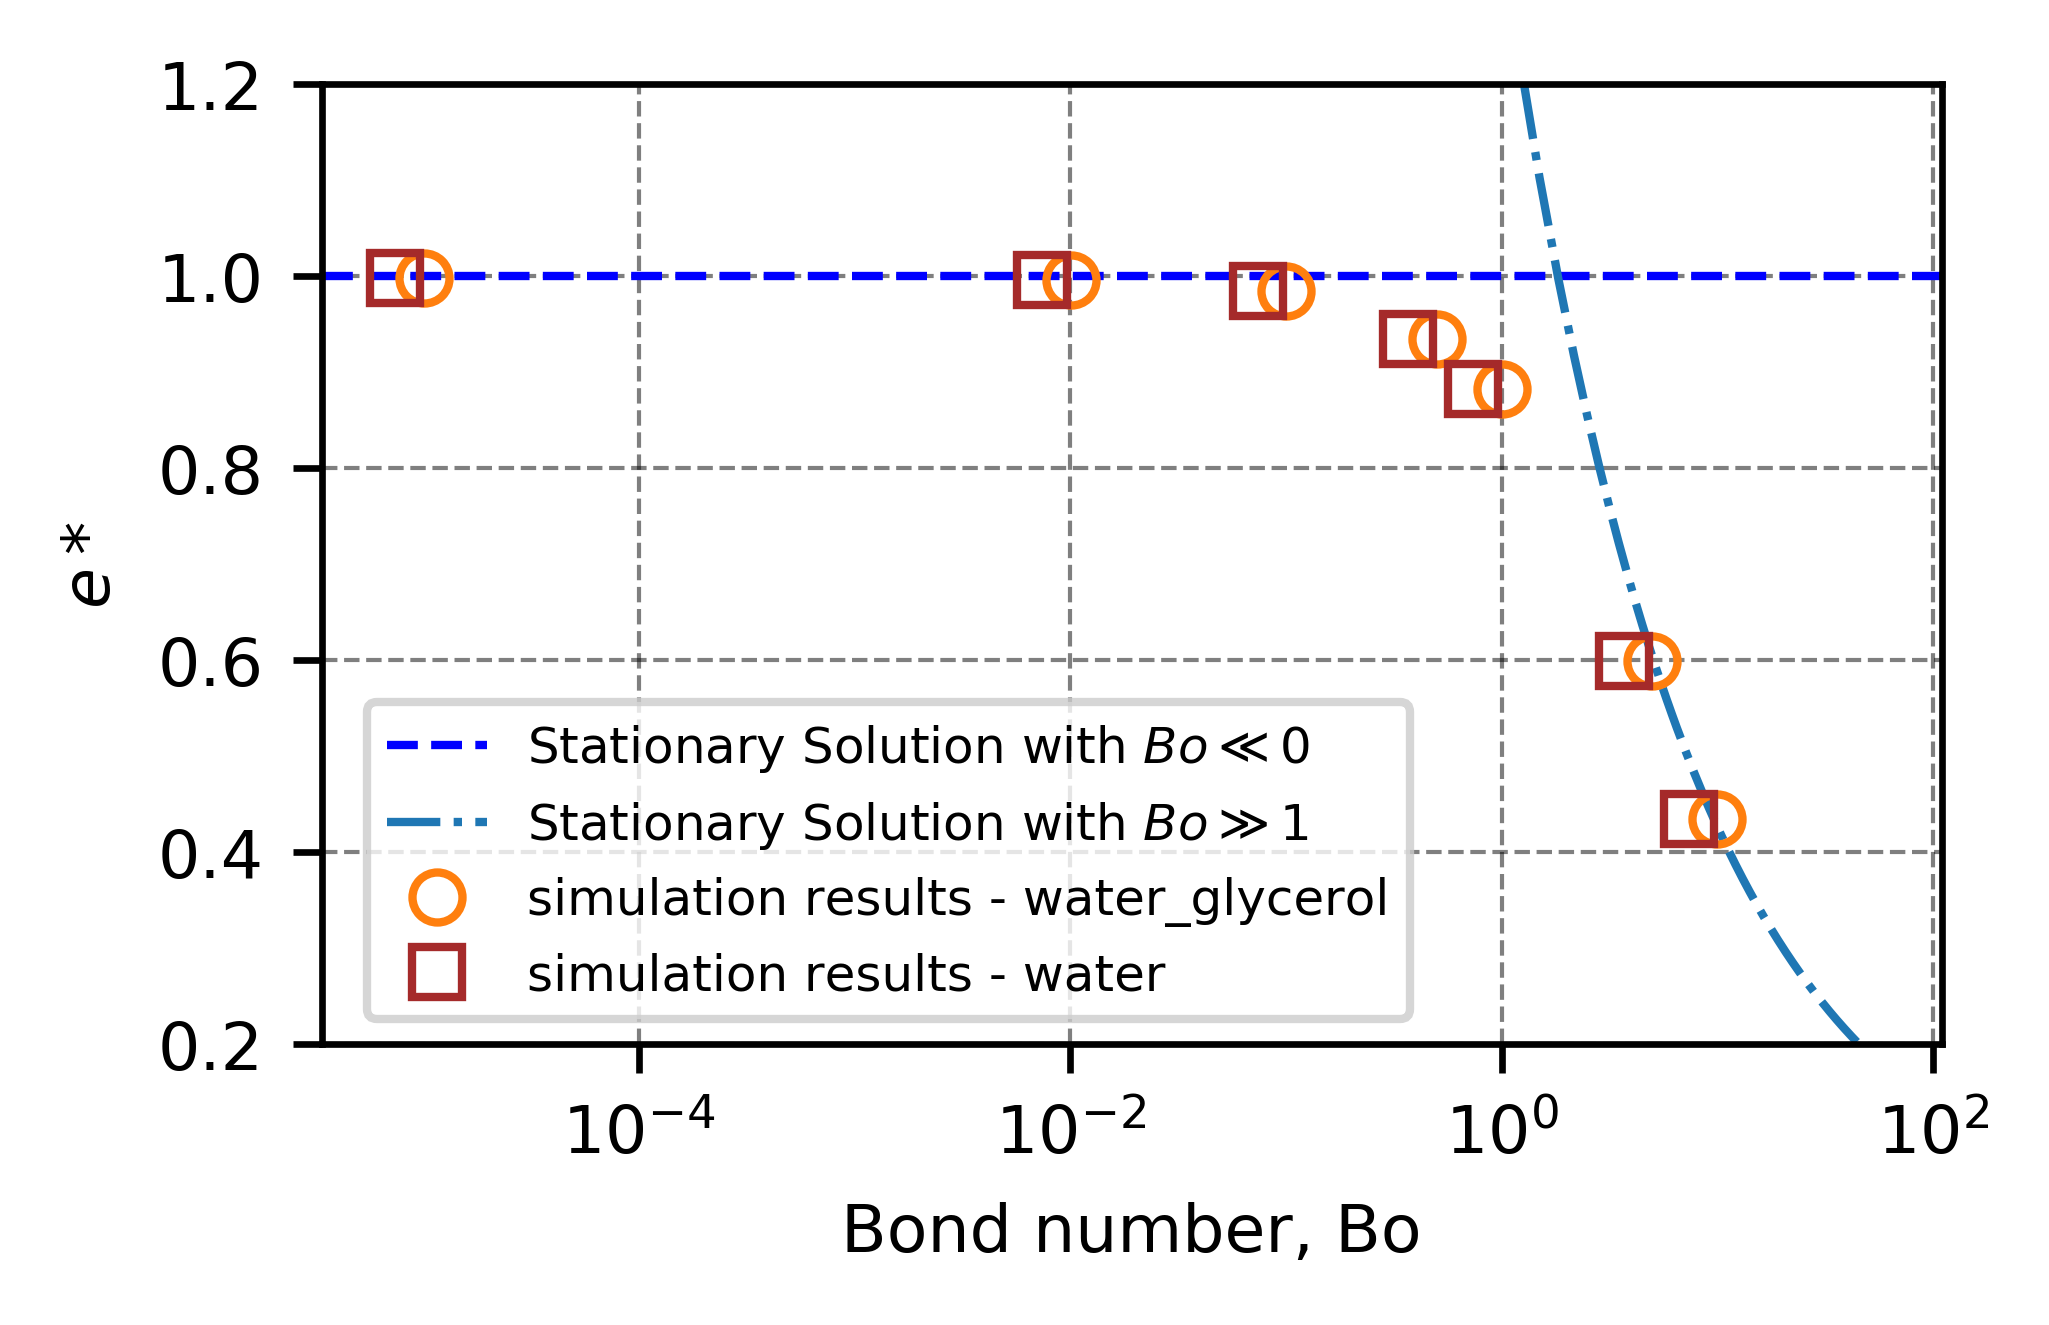

In [3]:
#Loading the necessary files
import pandas as pd
import numpy as np
from vtk import vtkStructuredPointsReader
from vtk.util import numpy_support as VN
import csv
# for radians
import math
import os
import matplotlib.pyplot as plt
import re
import itertools
from matplotlib import rcParams
import sys
pi =np.pi
sin = np.sin
cos = np.cos

rcParams["figure.dpi"] = 600
fontSize = 8
sys.path.append(os.path.join(os.getcwd(), '../../modules'))
print('modules path: ',os.path.join(os.getcwd(), '../../modules'))
from flat_spreading_funcs import Funcs

contactAngles = [70,110]
surfaceTensionModel = 'fitParaboloid' #surface tension model chosen for the simulations {heightFunction, RDF, fitParaboloid}
dataFolder = '/postProcessing/' #folder with .csv files

calcHeights = False #True is new simulation is run and height.csv file is needed to be updated from vtk files
#######################################################################################
#Fluid properties
sigma= 0.0635
row_l = 1194
Bo_List = np.linspace(0.5, 50, 150)
dropletRadius = 0.001 #R0
dropletVolume = 4/(2*3) * pi * dropletRadius**(3) #2 is because of semi-sphere, remove it for a full sphere
print('Droplet Volume = ' + str(dropletVolume) )
                    
##############################################################################################################
def getLists(var_Map):
    simStaticCAList= [] # static contact angles used for simulations taken from the variation file
    stm = [] # surface tension models in all cases,taken from the variation file
    var_list = [] # variance number of the parametric study of a specific case
    simgList = [] #gravity from the variation file
    for key, value in var_Map.items():
        stm_map = str(value).split(', ')[1][:-1] #surface tension model map
        stm.append(stm_map.split(': ')[1][1:])
        theta_map = str(value).split(', ')[2][:-1] #contact angle map
        simStaticCAList.append(int(theta_map.split(': ')[1][0:]))
        g_map = str(value).split(', ')[0] #gravitational acceleration map
        simgList.append(float(g_map.split(': ')[1][1:])) 
        var_list.append(str(key))  
    return(stm, simStaticCAList,simgList, var_list)

def plot(contactAngle):

    theta = math.radians(contactAngle) #static angle theta_e

    e_0 = Funcs.getAnalyticalWettedRadius(theta,dropletRadius)[1]
    print(e_0)
    
    #For Eo(Bo) >> 1, the droplet height is,
    def eInf(g):
        return 2*(sigma/(row_l*g))**(1/2) * (theta/2)

    eInf_list = [None] * 150

    for i, val in enumerate(Bo_List):
        g = Bo_List[i] * sigma / row_l /dropletRadius**(2)
        eInf_list[i] = eInf(g) / e_0

    ##########################################################################################################    
    fig = plt.figure()
    myaxes = fig.add_axes([0.1, 0.1, 0.45, 0.4])
    #Reference solution line
    plt.axhline(e_0/e_0, color='blue' , linestyle='dashed', linewidth=1, label = r"Stationary Solution with $Bo\ll0$")
    plt.plot(Bo_List, eInf_list, linewidth=1, linestyle='dashdot', label = r"Stationary Solution with $Bo\gg1$")

    ###############################################################################################################
    #WATER_GLLYCEROL
    pattern = 'wgtest'+str(contactAngle)+'_'
    
    var_Map = Funcs.fileMapping(pattern, surfaceTensionModel)
    
    stm = getLists(var_Map)[0]
    simStaticCAList = getLists(var_Map)[1]
    simgList = getLists(var_Map)[2]
    var_list = getLists(var_Map)[3]
    
    wettedAreaFileNames = Funcs.fileStructure(dataFolder, 'wettedArea.csv', pattern, var_list )
    vtk_folders = Funcs.fileStructure(dataFolder, 'surfaces/', pattern, var_list)
    heightFileNames = Funcs.fileStructure(dataFolder, 'height.csv', pattern,var_list)
    #print(heightFileNames)
    #print(wettedAreaFileNames)
    #print(vtk_folders)
    
    Funcs.writeHeightFile(calcHeights, wettedAreaFileNames, vtk_folders, heightFileNames)
    simBoList = [g/ sigma * row_l *dropletRadius**(2) for g in simgList] #Bond numbers in the simulation
    print('Bond numbers: ', simBoList)
    
    # #Plot equilibrium height against Eo number - water-glycerol
    equilibriumHeightList= [None] *7 
   
    theta = math.radians(contactAngle)

    nPointsForHeightAverage =5
    for idx, heightFile in enumerate(heightFileNames):
        avgHeight = 0
        for i in range(1, nPointsForHeightAverage):
            with open(heightFileNames[idx], "r") as f1:
                last_line = f1.readlines()[-i]
                avgHeight += float(last_line.rsplit(',', 1)[1])
        avgHeight /= (nPointsForHeightAverage-1)
        equilibriumHeightList[idx] = (avgHeight /e_0 ) 
     
    plt.plot(simBoList, equilibriumHeightList,  
                marker='o', markerfacecolor='None',
                linestyle = 'None', label=r"simulation results - water_glycerol")

    ###############################################################################################################

    #WATER
    sigma_w= 0.072
    rowl_w = 1000
    simBoList = [g/ sigma_w * rowl_w *dropletRadius**(2) for g in simgList] #Bond numbers in the simulation
    print('Bond numbers: ', simBoList)
    pattern = 'wgtest'+str(contactAngle)+'_'
    var_Map = Funcs.fileMapping(pattern, surfaceTensionModel)
    
    stm = getLists(var_Map)[0]
    simStaticCAList = getLists(var_Map)[1]
    simgList = getLists(var_Map)[2]
    var_list = getLists(var_Map)[3]
    
    wettedAreaFileNames = Funcs.fileStructure(dataFolder, 'wettedArea.csv', pattern, var_list )
    vtk_folders = Funcs.fileStructure(dataFolder, 'surfaces/', pattern, var_list)
    heightFileNames = Funcs.fileStructure(dataFolder, 'height.csv', pattern,var_list)
    #print(heightFileNames)
    #print(wettedAreaFileNames)
    #print(vtk_folders)
    
    Funcs.writeHeightFile(calcHeights, wettedAreaFileNames, vtk_folders, heightFileNames)

    #Plot equilibrium height against Eo number - water
    equilibriumHeightList= [None] *7 
   
    nPointsForHeightAverage = 5
    for idx, heightFile in enumerate(heightFileNames):
        avgHeight = 0
        for i in range(1, nPointsForHeightAverage):
            with open(heightFileNames[idx], "r") as f1:
                last_line = f1.readlines()[-i]
                avgHeight += float(last_line.rsplit(',', 1)[1])
        avgHeight /= (nPointsForHeightAverage-1)
        equilibriumHeightList[idx] = (avgHeight /e_0 ) 

    plt.plot(simBoList, equilibriumHeightList,  
                marker='s', markerfacecolor='None', c = 'brown',
                linestyle = 'None', label=r"simulation results - water")

    plt.grid(b=True, which='major', color='black', alpha=0.5, lw=0.5, linestyle='dashed')
    #plt.title(r'Normalized droplet height of a drop on'+'\n' + r'a flat surface with $\theta_s =$ ' +str(contactAngle)+'°', fontsize=fontSize)
    plt.xlabel(r"Bond number, Bo" ,color='black',fontsize=fontSize)
    plt.ylabel(r"$e*$",color='black',fontsize=fontSize)
    #plt.legend(fontsize=fontSize, loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=2)      
    #plt.xlim([0.0008, 15])
    plt.ylim([0.2, 1.2])
    plt.xscale('log')
    plt.xticks(fontsize=fontSize)
    plt.yticks(fontsize=fontSize)
    plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.35, 0), ncol=1)
    # ### Generate the plot
    plt.savefig('Normalized-droplet-height-plot-against-Bo-'+str(contactAngle)+'.png', bbox_inches='tight')
    plt.savefig('Normalized-droplet-height-plot-against-Bo-'+str(contactAngle)+'.pdf', bbox_inches='tight')
    plt.show()

for contactAngle in contactAngles:
    plot(contactAngle)